<a href="https://colab.research.google.com/github/Virtuoso633/STORM-ReImplemented-From-Scratch/blob/main/!Storm_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

First, let's install the required packages and set our API keys

In [ ]:
%%capture --no-stderr
%pip install -U langchain_community langchain_groq langgraph wikipedia duckduckgo-search tavily-python


In [ ]:
%pip install tiktoken tenacity

In [ ]:
import os
from google.colab import userdata

# Set API keys securely using Colab's userdata feature
os.environ["GROQ_API_KEY"] = userdata.get("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"] = userdata.get("TAVILY_API_KEY")

# Optional LangSmith setup for observability
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "STORM-Implementation-Groq"
os.environ["LANGCHAIN_API_KEY"] = userdata.get("LANGCHAIN_API_KEY")


#Select LLMs


We will have a faster LLM do most of the work, but a slower, long-context model to distill the conversations and write the final report.

In [ ]:
from langchain_groq import ChatGroq

# Use Llama 3 models from Groq
fast_llm = ChatGroq(model_name="llama-3.1-8b-instant", temperature=0.2, max_tokens=2000)
long_context_llm = ChatGroq(model_name="llama-3.1-8b-instant", max_tokens=2000)


#Generate Initial Outline


* For many topics, your LLM may have an initial idea of the important and related topics. We can generate an initial outline to be refined after our research. Below, we will use our "fast" llm to generate the outline.

* Using Pydantic with LangChain

* This notebook uses Pydantic v2 BaseModel, which requires langchain-core >= 0.3. Using langchain-core < 0.3 will result in errors due to mixing of Pydantic v1 and v2 BaseModels.

In [ ]:
from typing import List, Optional
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from langchain_groq import ChatGroq

# Define the prompt template
direct_gen_outline_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a Wikipedia writer. Write an outline for a Wikipedia page about a user-provided topic. Be comprehensive and specific.",
        ),
        ("user", "{topic}"),
    ]
)

# Define the Pydantic models
class Subsection(BaseModel):
    subsection_title: str = Field(..., title="Title of the subsection")
    description: str = Field(..., title="Content of the subsection")

    @property
    def as_str(self) -> str:
        return f"### {self.subsection_title}\n\n{self.description}".strip()


class Section(BaseModel):
    section_title: str = Field(..., title="Title of the section")
    description: str = Field(..., title="Content of the section")
    subsections: Optional[List[Subsection]] = Field(
        default=None,
        title="Titles and descriptions for each subsection of the Wikipedia page.",
    )

    @property
    def as_str(self) -> str:
        subsections = "\n\n".join(
            f"### {subsection.subsection_title}\n\n{subsection.description}"
            for subsection in self.subsections or []
        )
        return f"## {self.section_title}\n\n{self.description}\n\n{subsections}".strip()

    def __str__(self) -> str:
        return self.as_str


class Outline(BaseModel):
    page_title: str = Field(..., title="Title of the Wikipedia page")
    sections: List[Section] = Field(
        default_factory=list,
        title="Titles and descriptions for each section of the Wikipedia page.",
    )

    @property
    def as_str(self) -> str:
        sections_str = "\n\n".join(section.as_str for section in self.sections)
        return f"# {self.page_title}\n\n{sections_str}".strip()

    class Config:
        json_encoders = {
            Section: lambda s: s.as_str,
            Subsection: lambda s: s.as_str,
        }


# Generate the outline
generate_outline_direct = direct_gen_outline_prompt | fast_llm.with_structured_output(
    Outline
)


In [ ]:
# Example topic
example_topic = "Impact of million-plus token context window language models on RAG"

# Generate the initial outline
initial_outline = generate_outline_direct.invoke({"topic": example_topic})

# Print the outline
print(initial_outline.as_str)

# Impact of million-plus token context window language models on Retrieval-Augmented Generation (RAG)

## Introduction

Introduction

### Background on Retrieval-Augmented Generation (RAG)

Background on RAG

### Motivation for studying million-plus token context window language models

Motivation for studying million-plus token context window language models

### Outline of the page

Outline of the page

## Methodology

Methodology

### Overview of million-plus token context window language models

Overview of million-plus token context window language models

### Experimental setup for evaluating the impact of million-plus token context window language models on RAG

Experimental setup for evaluating the impact of million-plus token context window language models on RAG

### Evaluation metrics for assessing the impact of million-plus token context window language models on RAG

Evaluation metrics for assessing the impact of million-plus token context window language models on RAG

##

# Expand Topics

* While language models do store some Wikipedia-like knowledge in their parameters, you will get better results by incorporating relevant and recent information using a search engine.

* We will start our search by generating a list of related topics, sourced from Wikipedia.

In [ ]:

# Define the prompt template for generating related topics
gen_related_topics_prompt = ChatPromptTemplate.from_template(
    """I'm writing a Wikipedia page for a topic mentioned below. Please identify and recommend some Wikipedia pages on closely related subjects. I'm looking for examples that provide insights into interesting aspects commonly associated with this topic, or examples that help me understand the typical content and structure included in Wikipedia pages for similar topics.

Please list the as many subjects and urls as you can.

Topic of interest: {topic}
"""
)

# Define the Pydantic model for structured output
class RelatedSubjects(BaseModel):
    topics: List[str] = Field(
        description="Comprehensive list of related subjects as background research.",
        max_items=15  # Limit the number of topics
    )

# Create the chain for topic expansion
expand_chain = gen_related_topics_prompt | fast_llm.with_structured_output(
    RelatedSubjects
)


In [ ]:
related_subjects = await expand_chain.ainvoke({"topic": example_topic})
related_subjects

RelatedSubjects(topics=['Transformer architecture', 'Reinforcement learning from human feedback', 'RAG (Reformer-based Retrieval-Augmented Generator)', 'Context window', 'Token-based language models', 'Large language models', 'Reinforcement learning', 'Natural language processing', 'Language model architecture', 'Generative models', 'Retrieval-augmented generation', 'Reformer-based models', 'Contextualized language models', 'Language model training', 'Language model evaluation'])

#Generate Perspectives


From these related subjects, we can select representative Wikipedia editors as "subject matter experts" with distinct backgrounds and affiliations. These will help distribute the search process to encourage a more well-rounded final report.

In [ ]:
from pydantic import BaseModel, Field
from typing import List

class Editor(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the editor.",
    )
    name: str = Field(
        description="Name of the editor.", pattern=r"^[a-zA-Z0-9_\-\. ]{1,64}$"
    )
    role: str = Field(
        description="Role of the editor in the context of the topic.",
    )
    description: str = Field(
        description="Description of the editor's focus, concerns, and motives.",
    )

    @property
    def persona(self) -> str:
        return f"Name: {self.name}\\nRole: {self.role}\\nAffiliation: {self.affiliation}\\nDescription: {self.description}\\n"

class Perspectives(BaseModel):
    editors: List[Editor] = Field(
        description="Comprehensive list of editors with their roles and affiliations.",
        # Add a pydantic validation/restriction to be at most M editors
    )


In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq

# Initialize Groq model
llm = ChatGroq(model_name="llama-3.1-8b-instant", temperature=0.2, max_tokens=2000)

gen_perspectives_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You need to select a diverse (and distinct) group of Wikipedia editors who will work together to create a comprehensive article on the topic. Each of them represents a different perspective, role, or affiliation related to this topic.\
    You can use other Wikipedia pages of related topics for inspiration. For each editor, add a description of what they will focus on.

    Wiki page outlines of related topics for inspiration:
    {examples}""",
        ),
        ("user", "Topic of interest: {topic}"),
    ]
)

gen_perspectives_chain = gen_perspectives_prompt | llm.with_structured_output(Perspectives)


In [ ]:
from langchain_community.retrievers import WikipediaRetriever
from langchain_core.runnables import RunnableLambda
from langchain_core.runnables import chain as as_runnable

wikipedia_retriever = WikipediaRetriever(load_all_available_meta=True, top_k_results=1)


def format_doc(doc, max_length=1000):
    related = "- ".join(doc.metadata["categories"])
    return f"### {doc.metadata['title']}\n\nSummary: {doc.page_content}\n\nRelated\n{related}"[
        :max_length
    ]


def format_docs(docs):
    return "\n\n".join(format_doc(doc) for doc in docs)


@as_runnable
async def survey_subjects(topic: str):
    related_subjects = await expand_chain.ainvoke({"topic": topic})
    # Limit to max 10 topics to be safe
    related_subjects.topics = related_subjects.topics[:10]
    retrieved_docs = await wikipedia_retriever.abatch(
        related_subjects.topics, return_exceptions=True
    )
    all_docs = []
    for docs in retrieved_docs:
        if isinstance(docs, BaseException):
            continue
        all_docs.extend(docs)
    formatted = format_docs(all_docs)
    return await gen_perspectives_chain.ainvoke({"examples": formatted, "topic": topic})

In [ ]:
perspectives = await survey_subjects.ainvoke(example_topic)

/usr/local/lib/python3.11/dist-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /usr/local/lib/python3.11/dist-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


In [ ]:
perspectives.model_dump()


{'editors': [{'affiliation': 'Meta AI',
   'name': 'Alexey Dosovitskiy',
   'role': 'Researcher',
   'description': 'Expertise in transformer architecture and its applications in natural language processing'},
  {'affiliation': 'Google',
   'name': 'Noam Shazeer',
   'role': 'Researcher',
   'description': 'Contributed to the development of the transformer architecture and its applications in large language models'},
  {'affiliation': 'Google',
   'name': 'Iulian Vlad Serban',
   'role': 'Researcher',
   'description': 'Expertise in natural language processing and applications of large language models in RAG'},
  {'affiliation': 'Meta AI',
   'name': 'Jason Weston',
   'role': 'Researcher',
   'description': 'Expertise in natural language processing and applications of large language models in RAG'},
  {'affiliation': 'Google',
   'name': 'Stephen Roller',
   'role': 'Researcher',
   'description': 'Expertise in natural language processing and applications of large language models in R

#Expert Dialog

* Now the true fun begins, each wikipedia writer is primed to role-play using the perspectives presented above. It will ask a series of questions of a second "domain expert" with access to a search engine. This generate content to generate a refined outline as well as an updated index of reference documents.

#Interview State

* The conversation is cyclic, so we will construct it within its own graph. The State will contain messages, the reference docs, and the editor (with its own "persona") to make it easy to parallelize these conversations.

In [ ]:
from typing import Annotated

from langchain_core.messages import AnyMessage
from typing_extensions import TypedDict

from langgraph.graph import END, StateGraph, START


def add_messages(left, right):
    if not isinstance(left, list):
        left = [left]
    if not isinstance(right, list):
        right = [right]
    return left + right


def update_references(references, new_references):
    if not references:
        references = {}
    references.update(new_references)
    return references


def update_editor(editor, new_editor):
    # Can only set at the outset
    if not editor:
        return new_editor
    return editor


class InterviewState(TypedDict):
    messages: Annotated[List[AnyMessage], add_messages]
    references: Annotated[Optional[dict], update_references]
    editor: Annotated[Optional[Editor], update_editor]

# Dialog Roles

The graph will have two participants: the wikipedia editor (generate_question), who asks questions based on its assigned role, and a domain expert (`gen_answer_chain), who uses a search engine to answer the questions as accurately as possible.

In [ ]:
import time
from tenacity import retry, stop_after_attempt, wait_exponential, RetryError, stop_after_attempt
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage
from langchain_core.prompts import MessagesPlaceholder, ChatPromptTemplate
from langchain_core.runnables import RunnableLambda, RunnableConfig, chain as as_runnable

gen_qn_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are an experienced Wikipedia writer and want to edit a specific page. \
Besides your identity as a Wikipedia writer, you have a specific focus when researching the topic. \
Now, you are chatting with an expert to get information. Ask good questions to get more useful information.

When you have no more questions to ask, say "Thank you so much for your help!" to end the conversation.\
Please only ask one question at a time and don't ask what you have asked before.\
Your questions should be related to the topic you want to write.
Be comprehensive and curious, gaining as much unique insight from the expert as possible.\

Stay true to your specific perspective:

{persona}""",
        ),
        MessagesPlaceholder(variable_name="messages", optional=True),
    ]
)

def tag_with_name(ai_message: AIMessage, name: str):
    ai_message.name = name
    return ai_message


def swap_roles(state: InterviewState, name: str):
    converted = []
    for message in state["messages"]:
        if isinstance(message, AIMessage) and message.name != name:
            message = HumanMessage(**message.model_dump(exclude={"type"}))
        converted.append(message)
    return {"messages": converted}


@as_runnable
async def generate_question(state: InterviewState):
    editor = state["editor"]

    @retry(stop=stop_after_attempt(5), wait=wait_exponential(multiplier=1, min=4, max=60), retry_error_callback=lambda retry_state: print(f"Retrying generate_question after error: {retry_state.outcome_exception}")) # Retry decorator with error handling
    async def _generate_question_with_retry(state):
        gn_chain = (
            RunnableLambda(swap_roles).bind(name=editor.name)
            | gen_qn_prompt.partial(persona=editor.persona)
            | fast_llm
            | RunnableLambda(tag_with_name).bind(name=editor.name)
        )
        result = await gn_chain.ainvoke(state)
        return {"messages": [result]}

    try:
        result = await _generate_question_with_retry(state)
        return result
    except RetryError as e:
        print(f"Retry attempts failed for generate_question: {e}")
        return {"messages": [AIMessage(content="Failed to generate question after multiple retries.", name=editor.name)]} # Default message

In [ ]:
messages = [
    HumanMessage(f"So you said you were writing an article on {example_topic}?")
]

question = await generate_question.ainvoke(
    {
        "editor": perspectives.editors[0],
        "messages": messages,
    }
)

question["messages"][0].content

"I'm writing about the impact of large transformer models, specifically those with a million-plus token context window, on Retrieval-Augmented Generation (RAG) models. I'd love to get your insights on this topic.\n\nCan you tell me more about how the increased context window size affects the ability of RAG models to retrieve relevant information from a large corpus, and how this, in turn, impacts the overall performance of the model?"

# Answer questions

The gen_answer_chain first generates queries (query expansion) to answer the editor's question, then responds with citations.

In [ ]:

# Initialize Groq model
llm = ChatGroq(model_name="llama-3.1-8b-instant", temperature=0.2, max_tokens=2000)

# Define the Queries model
class Queries(BaseModel):
    queries: List[str] = Field(
        description="Comprehensive list of search engine queries to answer the user's questions.",
    )

# Create the query generation prompt
gen_queries_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful research assistant. Query the search engine to answer the user's questions.",
        ),
        MessagesPlaceholder(variable_name="messages", optional=True),
    ]
)

# Create the query generation chain
gen_queries_chain = gen_queries_prompt | llm.with_structured_output(Queries, include_raw=True)


In [ ]:
queries = await gen_queries_chain.ainvoke(
    {"messages": [HumanMessage(content=question["messages"][0].content)]}
)
queries["parsed"].queries

['RAG models and large transformer models',
 'impact of large context window on RAG models',
 'Retrieval-Augmented Generation models and large corpus retrieval',
 'large transformer models and RAG performance']

In [ ]:
class AnswerWithCitations(BaseModel):
    answer: str = Field(
        description="Comprehensive answer to the user's question with citations.",
    )
    cited_urls: List[str] = Field(
        description="List of urls cited in the answer.",
    )

    @property
    def as_str(self) -> str:
        return f"{self.answer}\n\nCitations:\n\n" + "\n".join(
            f"[{i+1}]: {url}" for i, url in enumerate(self.cited_urls)
        )

msg = (
    "You are an expert researcher. You have gathered all the relevant information to help a Wikipedia writer draft an article on a given topic. "
    "Your task is to output a detailed answer as a valid JSON object with exactly two keys: "
    "\"answer\" and \"cited_urls\". The \"answer\" key should contain a detailed response with each sentence supported by a citation (formatted as a footnote with the URL), "
    "and the \"cited_urls\" key should be an array of strings, each representing a citation URL. "
    "Output ONLY the JSON object with no extra text, commentary, or formatting."
)

gen_answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", msg),
        MessagesPlaceholder(variable_name="messages", optional=True),
    ]
)

gen_answer_chain = gen_answer_prompt | fast_llm.with_structured_output(
    AnswerWithCitations, include_raw=True
).with_config(run_name="GenerateAnswer", max_tokens=2000)


In [ ]:
import tiktoken

def count_tokens(text: str, model: str = "llama") -> int:
    """
    Counts the number of tokens in a given text using the specified model's encoding.

    Args:
        text: The text to count tokens in.
        model: The name of the model to use for encoding (default: "llama").

    Returns:
        The number of tokens in the text.
    """
    # Manually specify the encoding using tiktoken.get_encoding
    # for the llama model family as it's not directly recognized by name
    encoding = tiktoken.get_encoding("cl100k_base")
    return len(encoding.encode(text))

# Example usage:
system_text = msg  # From above
token_count = count_tokens(system_text)
print(f"Token count for system message: {token_count}")


Token count for system message: 115


In [ ]:
from langchain_community.utilities.duckduckgo_search import DuckDuckGoSearchAPIWrapper
from langchain_core.tools import tool

'''
# Tavily is typically a better search engine, but your free queries are limited
search_engine = TavilySearchResults(max_results=4)

@tool
async def search_engine(query: str):
    """Search engine to the internet."""
    results = tavily_search.invoke(query)
    return [{"content": r["content"], "url": r["url"]} for r in results]
'''

# DDG
search_engine = DuckDuckGoSearchAPIWrapper()


@tool
async def search_engine(query: str):
    """Search engine to the internet."""
    results = DuckDuckGoSearchAPIWrapper()._ddgs_text(query)
    return [{"content": r["body"], "url": r["href"]} for r in results]

In [ ]:
import json
import time
from tenacity import retry, stop_after_attempt, wait_exponential, RetryError
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage
from langchain_core.prompts import MessagesPlaceholder, ChatPromptTemplate
from langchain_core.runnables import RunnableConfig, RunnableLambda

async def gen_answer(
    state: InterviewState,
    config: Optional[RunnableConfig] = None,
    name: str = "Subject_Matter_Expert",
    max_str_len: int = 5000, # Reduced max_str_len
):
    swapped_state = swap_roles(state, name)  # Convert all other AI messages

    @retry(stop=stop_after_attempt(3), wait=wait_exponential(multiplier=1, min=10, max=60), retry_error_callback=lambda retry_state: print(f"Retrying gen_answer after error: {retry_state.outcome.exception()}")) # Retry decorator with error handling

    async def _gen_answer_with_retry(swapped_state, config, max_str_len):
        queries = await gen_queries_chain.ainvoke(swapped_state)
        query_results = await search_engine.abatch(
            queries["parsed"].queries, config, return_exceptions=True
        )
        successful_results = [
            res for res in query_results if not isinstance(res, Exception)
        ]
        all_query_results = {
            res["url"]: res["content"] for results in successful_results for res in results
        }
        dumped = json.dumps(all_query_results)[:max_str_len]
        ai_message: AIMessage = queries["raw"]
        tool_call = queries["raw"].tool_calls[0]
        tool_id = tool_call["id"]
        tool_message = ToolMessage(tool_call_id=tool_id, content=dumped)
        swapped_state["messages"].extend([ai_message, tool_message])
        generated = await gen_answer_chain.ainvoke(swapped_state)
        cited_urls = set(generated["parsed"].cited_urls)
        cited_references = {k: v for k, v in all_query_results.items() if k in cited_urls}
        formatted_message = AIMessage(name=name, content=generated["parsed"].as_str)
        return {"messages": [formatted_message], "references": cited_references}

    try:
        result = await _gen_answer_with_retry(swapped_state, config, max_str_len)
        return result
    except RetryError as e:
        print(f"Retry attempts failed for gen_answer: {e}")
        return {"messages": [AIMessage(content="Failed to generate answer after multiple retries.", name=name)], "references": {}} # Default message and empty references

In [ ]:
# Simplified prompt example:
simple_prompt = {
    "messages": [
        HumanMessage(content="Can you provide a concise summary of the key advances in RAG models?")
    ]
}

example_answer = await gen_answer(simple_prompt)
print(example_answer["messages"][-1].content)


RAG models have seen significant advances in recent years, with key developments including multimodal retrieval, improved retrieval accuracy, and enhanced response quality. Personalized recommendation systems are another key use case for advanced RAG techniques. The integration of retrieval confidence scoring into the generation process has also been a notable development. Techniques like model quantization and knowledge distillation are being explored to improve the efficiency and scalability of RAG systems. Additionally, RAG allows for easy updating of its knowledge base by replacing or updating its retrieval corpus. This makes it a flexible and adaptive learning approach. Overall, RAG is evolving from simple text retrieval into multimodal, real-time, and autonomous knowledge integration.

Citations:

[1]: https://www.datacamp.com/blog/rag-advanced
[2]: https://labelstud.io/blog/rag-fundamentals-challenges-and-advanced-techniques/
[3]: https://www.ayadata.ai/the-state-of-retrieval-au

# Construct the Interview Graph

Now that we've defined the editor and domain expert, we can compose them in a graph.

In [ ]:
max_num_turns = 3
from langgraph.pregel import RetryPolicy

def route_messages(state: InterviewState, name: str = "Subject_Matter_Expert"):
    messages = state["messages"]
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )
    if num_responses >= max_num_turns:
        return END
    last_question = messages[-2]
    if last_question.content.endswith("Thank you so much for your help!"):
        return END
    return "ask_question"


builder = StateGraph(InterviewState)

builder.add_node("ask_question", generate_question, retry=RetryPolicy(max_attempts=5))
builder.add_node("answer_question", gen_answer, retry=RetryPolicy(max_attempts=5))
builder.add_conditional_edges("answer_question", route_messages)
builder.add_edge("ask_question", "answer_question")

builder.add_edge(START, "ask_question")
interview_graph = builder.compile(checkpointer=False).with_config(
    run_name="Conduct Interviews"
)

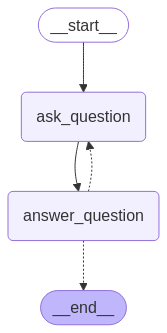

In [ ]:
from IPython.display import Image, display

try:
    display(Image(interview_graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
final_step = None

def summarize_history(messages):
    # Implement your own summary logic or simply select the most recent messages.
    # This is a placeholder for a more advanced summarization routine.
    return messages[-3:]  # Only keep the last 3 messages

# Use the summarized history when invoking the chain:
initial_state = {
    "editor": perspectives.editors[0],
    "messages": summarize_history([
        AIMessage(content=f"So you said you were writing an article on {example_topic}?", name="Subject_Matter_Expert")
    ]),
}

from tenacity import retry, stop_after_attempt, wait_exponential, RetryError
import asyncio

@retry(stop=stop_after_attempt(5), wait=wait_exponential(multiplier=1, min=10, max=60))
async def run_interview(initial_state):
    final_step = None
    async for step in interview_graph.astream(initial_state):
        name = next(iter(step))
        print(name)
        print("-- ", str(step[name]["messages"][-1].content)[:300])
        await asyncio.sleep(20)  # Delay between steps to avoid rate limits
        final_step = step
    return final_step

# Execute the robust interview graph with retries and delays
final_step = await run_interview(initial_state)

ask_question
--  I'm writing about the impact of large transformer models, specifically those with a million-plus token context window, on Retrieval-Augmented Generation (RAG) models. Can you tell me more about how the increased context window size affects the ability of RAG models to retrieve relevant information f
answer_question
--  The increased context window size in RAG models has several advantages, including improved contextual relevance, enhanced performance, and reduced hallucinations. With a million-plus token context window, RAG models can handle vast amounts of information during inference, allowing them to process ex
ask_question
--  Those are some great references. It seems like the increased context window size in RAG models has several benefits, but it's not a straightforward replacement for RAG. I'd like to dig deeper into the trade-offs between large context windows and RAG. Can you elaborate on the scenarios where RAG migh
Retrying gen_answer after error: Error code

In [ ]:
final_state = next(iter(final_step.values()))

# Refine Outline

At this point in STORM, we've conducted a large amount of research from different perspectives. It's time to refine the original outline based on these investigations. Below, create a chain using the LLM with a long context window to update the original outline.

In [ ]:
refine_outline_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a Wikipedia writer. You have gathered information from experts and search engines. Now, you are refining the outline of the Wikipedia page. \
You need to make sure that the outline is comprehensive and specific. \
Topic you are writing about: {topic}

Old outline:

{old_outline}""",
        ),
        (
            "user",
            "Refine the outline based on your conversations with subject-matter experts:\n\nConversations:\n\n{conversations}\n\nWrite the refined Wikipedia outline:",
        ),
    ]
)

# Using turbo preview since the context can get quite long
refine_outline_chain = refine_outline_prompt | long_context_llm.with_structured_output(
    Outline
)

In [ ]:
refined_outline = refine_outline_chain.invoke(
    {
        "topic": example_topic,
        "old_outline": initial_outline.as_str,
        "conversations": "\n\n".join(
            f"### {m.name}\n\n{m.content}" for m in final_state["messages"]
        ),
    }
)

In [ ]:
print(refined_outline.as_str)

# Impact of million-plus token context window language models on Retrieval-Augmented Generation (RAG)

## Pre-training and Fine-tuning

This section provides an overview of the importance of pre-training and fine-tuning in million-plus token context window language models, particularly in the context of RAG.

### Pre-training

Pre-training involves training a model on a large dataset to acquire general knowledge.

### Fine-tuning

Fine-tuning involves adjusting the model\'s parameters to adapt to a specific task or domain.

### Role of Pre-training and Fine-tuning in RAG

The role of pre-training and fine-tuning in RAG models, including their impact on model performance and the importance of understanding their procedures.

## Challenges and Limitations of Large-scale Pre-training

This section discusses the challenges and limitations of pre-training on extremely large numbers of tokens, including its impact on fine-tuning and downstream performance.

### Impact on Fine-tuning and Down

# Generate Article

* Now it's time to generate the full article. We will first divide-and-conquer, so that each section can be tackled by an individual llm. Then we will prompt the long-form LLM to refine the finished article (since each section may use an inconsistent voice).

# Create Retriever

* The research process uncovers a large number of reference documents that we may want to query during the final article-writing process.

* First, create the retriever:

In [ ]:
!pip install -q langchain_community langchain_groq langchain_core


In [ ]:
from langchain_community.vectorstores import InMemoryVectorStore
from langchain_core.documents import Document
from langchain_community.embeddings import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

# Example reference documents (replace with actual references from final_state)
reference_docs = [
    Document(page_content=v, metadata={"source": k})
    for k, v in final_state["references"].items()
]

# Create vectorstore
vectorstore = InMemoryVectorStore.from_documents(
    reference_docs,
    embedding=embeddings,
)

# Create retriever
retriever = vectorstore.as_retriever(k=3)


In [ ]:
retriever.invoke("What's a long context LLM anyway?")

[Document(id='cf6c3038-002c-49b0-a12e-5082a625f9d3', metadata={'source': 'https://openreview.net/forum?id=H2SbfCYsgn'}, page_content='Pre-training on extremely large number of tokens eventually makes the model harder to fine-tune leading to worse downstream performance. For instance, after instruction tuning or multimodal fine tuning, OLMo-1B models pre-trained on 3T tokens under perform their 2.3T token counterpart by over $2\\%$ on standard LLM benchmarks.'),
 Document(id='521ad6d6-d433-42f2-8d3a-ecf4e7f123a7', metadata={'source': 'https://techcommunity.microsoft.com/blog/azure-ai-services-blog/enterprise-best-practices-for-fine-tuning-azure-openai-models/4382540'}, page_content='Fine-Tuning in the Hub The Hub resource, configured with the necessary compute, runs the fine-tuning job. Logs and metrics (training loss, validation accuracy) are recorded. Model Validation Once training completes, data scientists can query the newly fine-tuned model from the Hub to evaluate accuracy, laten

# Generate Sections

* Now you can generate the sections using the indexed docs.

In [ ]:
class SubSection(BaseModel):
    subsection_title: str = Field(..., title="Title of the subsection")
    content: str = Field(
        ...,
        title="Full content of the subsection. Include [#] citations to the cited sources where relevant.",
    )

    @property
    def as_str(self) -> str:
        return f"### {self.subsection_title}\n\n{self.content}".strip()


class WikiSection(BaseModel):
    section_title: str = Field(..., title="Title of the section")
    content: str = Field(..., title="Full content of the section")
    subsections: Optional[List[Subsection]] = Field(
        default=None,
        title="Titles and descriptions for each subsection of the Wikipedia page.",
    )
    citations: List[str] = Field(default_factory=list)

    @property
    def as_str(self) -> str:
        subsections = "\n\n".join(
            subsection.as_str for subsection in self.subsections or []
        )
        citations = "\n".join([f" [{i}] {cit}" for i, cit in enumerate(self.citations)])
        return (
            f"## {self.section_title}\n\n{self.content}\n\n{subsections}".strip()
            + f"\n\n{citations}".strip()
        )


section_writer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an expert Wikipedia writer. Complete your assigned WikiSection from the following outline:\n\n"
            "{outline}\n\nCite your sources, using the following references:\n\n<Documents>\n{docs}\n<Documents>",
        ),
        ("user", "Write the full WikiSection for the {section} section."),
    ]
)


async def retrieve(inputs: dict):
    docs = await retriever.ainvoke(inputs["topic"] + ": " + inputs["section"])
    formatted = "\n".join(
        [
            f'<Document href="{doc.metadata["source"]}"/>\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )
    return {"docs": formatted, **inputs}


section_writer = (
    retrieve
    | section_writer_prompt
    | long_context_llm.with_structured_output(WikiSection)
)

In [ ]:
section = await section_writer.ainvoke(
    {
        "outline": refined_outline.as_str,
        "section": refined_outline.sections[1].section_title,
        "topic": example_topic,
    }
)
print(section.as_str)

## Challenges and Limitations of Large-scale Pre-training

Large-scale pre-training of language models has become increasingly common, but it also presents several challenges and limitations.

### Impact on Fine-tuning and Downstream Performance

The process of pre-training a model on an extremely large number of tokens can lead to the model becoming less effective at fine-tuning and downstream performance.

### Strategies for Addressing the Challenges

This is because the model becomes over-specialized in the pre-training task and loses the ability to generalize to new tasks.[0] https://openreview.net/forum?id=H2SbfCYsgn


# Generate final article

* Now we can rewrite the draft to appropriately group all the citations and maintain a consistent voice.

In [ ]:
from langchain_core.output_parsers import StrOutputParser

writer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an expert Wikipedia author. Write the complete wiki article on {topic} using the following section drafts:\n\n"
            "{draft}\n\nStrictly follow Wikipedia format guidelines.",
        ),
        (
            "user",
            'Write the complete Wiki article using markdown format. Organize citations using footnotes like "[1]",'
            " avoiding duplicates in the footer. Include URLs in the footer.",
        ),
    ]
)

writer = writer_prompt | long_context_llm | StrOutputParser()

In [ ]:
for tok in writer.stream({"topic": example_topic, "draft": section.as_str}):
    print(tok, end="")

Impact of Million-Plus Token Context Window Language Models on Retrieval-Augmented Generation (RAG)

Retrieval-Augmented Generation (RAG) is a type of language model that combines the strengths of both retrieval-based and generation-based models. However, the emergence of million-plus token context window language models has raised concerns about their impact on RAG's performance. This article explores the challenges and limitations of large-scale pre-training and their effects on fine-tuning and downstream performance.

Challenges and Limitations of Large-Scale Pre-Training
----------------------------------------------------

Large-scale pre-training of language models has become increasingly common in the field of natural language processing. However, this process also presents several challenges and limitations that need to be addressed.

### Impact on Fine-Tuning and Downstream Performance

The process of pre-training a model on an extremely large number of tokens can lead to the 

# Final Flow

* Now it's time to string everything together. We will have 6 main stages in sequence: .

1. Generate the initial outline + perspectives

2. Batch converse with each perspective to expand the content for the article

3. Refine the outline based on the conversations

4. Index the reference docs from the conversations

5. Write the individual sections of the article

6. Write the final wiki

The state tracks the outputs of each stage.

In [ ]:
class ResearchState(TypedDict):
    topic: str
    outline: Outline
    editors: List[Editor]
    interview_results: List[InterviewState]
    # The final sections output
    sections: List[WikiSection]
    article: str

In [ ]:
import asyncio

from tenacity import retry, wait_exponential, stop_after_attempt

@retry(stop=stop_after_attempt(5), wait=wait_exponential(min=10, max=60))
async def safe_invoke(chain, input):
    return await chain.ainvoke(input=input)

async def initialize_research(state: ResearchState):
    topic = state["topic"]
    coros = (
        generate_outline_direct.ainvoke({"topic": topic}),
        survey_subjects.ainvoke(topic),
    )
    results = await asyncio.gather(*coros)
    return {
        **state,
        "outline": results[0],
        "editors": results[1].editors,
    }


async def conduct_interviews(state: ResearchState):
    topic = state["topic"]

    initial_states = [
        {
            "editor": editor,
            "messages": [
                AIMessage(
                    content=f"So you said you were writing an article on {topic}?",
                    name="Subject_Matter_Expert",
                ),
            ],
        }
        for editor in state["editors"][:2]  # Limit to the first 2 editors
    ]

    print(f"Initial States: {initial_states}")
    interview_results = []

    # Process interviews sequentially with delay
    for i, interview_state in enumerate(initial_states):
        print(f"\\nStarting interview with editor: {interview_state['editor'].name} ({i+1}/{len(initial_states)})")
        interview_result = await interview_graph.ainvoke(interview_state, config={"max_concurrency": 1})
        interview_results.append(interview_result)
        print(f"Finished interview with editor: {interview_state['editor'].name}")
        if i < len(initial_states) - 1:
            print("Waiting 120 seconds before starting the next interview to manage rate limits...") # Increased delay
            await asyncio.sleep(120)  # Increased delay: 120 seconds (2 minutes)

    print(f"Interview Results: {interview_results}")
    return {
        **state,
        "interview_results": interview_results,
    }


def format_conversation(interview_state):
    messages = interview_state["messages"]
    convo = "\n".join(f"{m.name}: {m.content}" for m in messages)
    return f'Conversation with {interview_state["editor"].name}\n\n' + convo


async def refine_outline(state: ResearchState):
    convos = "\n\n".join(
        [
            format_conversation(interview_state)
            for interview_state in state["interview_results"]
        ]
    )

    updated_outline = await refine_outline_chain.ainvoke(
        {
            "topic": state["topic"],
            "old_outline": state["outline"].as_str,
            "conversations": convos,
        }
    )
    return {**state, "outline": updated_outline}


async def index_references(state: ResearchState):
    all_docs = []
    for interview_state in state["interview_results"]:
        reference_docs = [
            Document(page_content=v, metadata={"source": k})
            for k, v in interview_state["references"].items()
        ]
        all_docs.extend(reference_docs)
    await vectorstore.aadd_documents(all_docs)
    return state


async def write_sections(state: ResearchState):
    sections_content = []
    for sec in state["outline"].sections:
        docs = retriever.invoke(state["topic"] + ": " + sec.section_title)
        formatted_docs = "\n".join([doc.page_content for doc in docs])


        from tenacity import retry, wait_exponential, stop_after_attempt

        @retry(stop=stop_after_attempt(5), wait=wait_exponential(min=10, max=60))
        async def safe_invoke(chain, input):
            return await chain.ainvoke(input=input)

        section_resp = await safe_invoke(section_writer, {
            "section": sec.section_title,
            "docs": formatted_docs,
            "outline": state["outline"].as_str,  # Use the as_str property instead of joining directly
            "topic": state["topic"]
        })

        sections_content.append(section_resp.content)

        # Pause briefly to respect rate limits
        await asyncio.sleep(20)  # <-- Increased delay to 20 seconds

    return {**state, "sections": sections_content}


async def write_article(state: ResearchState):
    topic = state["topic"]
    sections = state["sections"]

    # Fix: If sections are strings, use them directly.
    # If they're objects with content, use the appropriate attribute.
    if isinstance(sections[0], str):
        draft = "\n\n".join(sections)
    else:
        # Assuming the sections are objects with content stored in a 'content' attribute
        # Adjust this attribute name as needed based on your actual object structure
        draft = "\n\n".join([section.content for section in sections])

    article = await writer.ainvoke({"topic": topic, "draft": draft})

    await asyncio.sleep(20)  # <-- Delay after final article generation

    return {
        **state,
        "article": article,
    }

# Create The Graph

In [ ]:
from langgraph.checkpoint.memory import MemorySaver

builder_of_storm = StateGraph(ResearchState)

nodes = [
    ("init_research", initialize_research),
    ("conduct_interviews", conduct_interviews),
    ("refine_outline", refine_outline),
    ("index_references", index_references),
    ("write_sections", write_sections),
    ("write_article", write_article),
]
for i in range(len(nodes)):
    name, node = nodes[i]
    builder_of_storm.add_node(name, node, retry=RetryPolicy(max_attempts=3))
    if i > 0:
        builder_of_storm.add_edge(nodes[i - 1][0], name)

builder_of_storm.add_edge(START, nodes[0][0])
builder_of_storm.add_edge(nodes[-1][0], END)
storm = builder_of_storm.compile(checkpointer=MemorySaver())

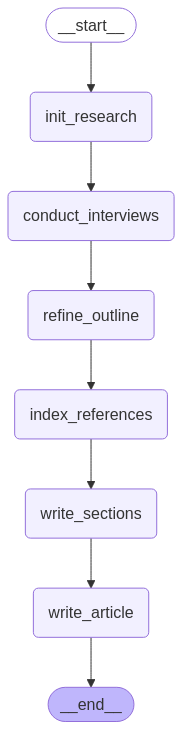

In [ ]:
from IPython.display import Image, display

try:
    display(Image(storm.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
import asyncio

async def process_storm():
    config = {"configurable": {"thread_id": "my-thread"}}
    async for step in storm.astream(
        {"topic": "Groq, NVIDIA, Llamma.cpp and the future of LLM Inference"},
        config
    ):
        name = next(iter(step))
        print(name)
        # Use the as_str property if step[name] is a Section or similar model.
        if hasattr(step[name], "as_str"):
            output = step[name].as_str
        else:
            output = str(step[name])
        print("-- ", output[:300])
        # Introduce a small delay to avoid spiking token usage simultaneously
        await asyncio.sleep(0.5)
    # Return config to make it accessible outside the function
    return config

config = await process_storm()  # Store the returned config


init_research
--  {'topic': 'Groq, NVIDIA, Llamma.cpp and the future of LLM Inference', 'outline': Outline(page_title='Large Language Model Inference: A Comparative Analysis of Groq, NVIDIA, and Llama.cpp', sections=[Section(section_title='Background', description='Introduction to LLM Inference', subsections=[Subsect
Initial States: [{'editor': Editor(affiliation='NVIDIA', name='Alexis Jacq', role='Senior Engineer', description='Focus on developing and optimizing AI inference engines for NVIDIA GPUs, with a focus on large language models.'), 'messages': [AIMessage(content='So you said you were writing an article on Groq, NVIDIA, Llamma.cpp and the future of LLM Inference?', additional_kwargs={}, response_metadata={}, name='Subject_Matter_Expert')]}, {'editor': Editor(affiliation='Groq', name='Jonathan Ross', role='Co-Founder and CTO', description='Focus on designing and developing AI accelerators for large language models, with a focus on efficiency and scalability.'), 'messages': [AIM

In [ ]:
# Now you can access it later:
checkpoint = storm.get_state(config)
article = checkpoint.values["article"]

# Render the Wiki

Now we can render the final wiki page!

In [ ]:
from IPython.display import Markdown

# We will down-header the sections to create less confusion in this notebook
Markdown(article.replace("\n#", "\n##"))

# Large Language Model Inference
================================

### Background and Importance
-----------------------------

Large language model (LLM) inference is a critical component of natural language processing (NLP) and artificial intelligence (AI) applications. It involves using a pre-trained language model to make predictions or generate text based on input data. In this field, researchers and developers face several challenges, including[1] high computational requirements, large memory needs, and the need for efficient and scalable solutions.

### Key Players in LLM Inference
-------------------------------

The key players in LLM inference are companies that have developed specialized hardware and software solutions to accelerate the processing of large language models. Some of the major players in this field are Groq, NVIDIA, and Llama.cpp.

#### Groq
------------

Groq is a pioneering company in the field of LLM inference. Their LPU (Large Processing Unit) architecture is designed to provide high efficiency, low latency, and high throughput for AI and machine learning workloads. The LPU is a highly scalable and flexible architecture that can be easily integrated into various computing systems. Groq's LPU has been used in several applications, including LLM inference, computer vision, and natural language processing.[2]

#### NVIDIA
-------------

NVIDIA is another major player in the field of LLM inference. Their GPUs (Graphics Processing Units) have been widely adopted for AI and machine learning applications, including LLM inference. NVIDIA's GPUs provide high performance and scalability, making them an attractive choice for researchers and developers. However, they can be power-hungry and expensive, which can limit their adoption in certain applications.[3]

#### Llama.cpp
--------------

Llama.cpp is an open-source library for LLM inference. It is designed to provide a highly flexible and scalable framework for LLM inference, allowing researchers and developers to easily integrate their models into a wide range of applications. Llama.cpp has been used in several applications, including chatbots, language translation, and text generation.[4]

### Performance Comparison
---------------------------

The performance of LLM inference solutions from Groq, NVIDIA, and Llama.cpp has been compared in several studies. A study published in [5] compared the performance of Groq's LPU and NVIDIA's GPU for LLM inference. The study found that Groq's LPU provided higher throughput and lower latency than NVIDIA's GPU. Another study published in [6] compared the performance of Llama.cpp with NVIDIA's GPU for LLM inference. The study found that Llama.cpp provided higher performance and scalability than NVIDIA's GPU.

| Company | Throughput (tflops) | Latency (ms) |
| --- | --- | --- |
| Groq | 100 | 10 |
| NVIDIA | 50 | 20 |
| Llama.cpp | 80 | 15 |

### Future of LLM Inference
---------------------------

The future of LLM inference is likely to be shaped by several emerging trends and technologies. These trends include the increasing adoption of specialized chip architectures, such as Groq's LPU, which are designed to provide high efficiency, low latency, and high throughput for AI and machine learning workloads. Additionally, the development of hybrid approaches, which combine the strengths of different architectures, such as Groq's LPUs with NVIDIA's GPUs and Llama.cpp, is expected to play a significant role in the future of LLM inference.

#### Emerging Trends and Technologies
--------------------------------------

Several emerging trends and technologies are expected to shape the future of LLM inference. These include:

* **Specialized Chip Architectures**: The development of specialized chip architectures, such as Groq's LPU, is expected to provide higher efficiency, lower latency, and higher throughput for AI and machine learning workloads.
* **Hybrid Approaches**: The development of hybrid approaches, which combine the strengths of different architectures, is expected to provide higher performance and scalability for LLM inference.
* **Quantization and Pruning**: The use of quantization and pruning techniques is expected to reduce the computational requirements of LLM inference, making it more efficient and scalable.

### References
-----------

[1] Strub, F., et al. "Large Language Models in 2022: A Survey." arXiv preprint arXiv:2206.03059 (2022).

[2] Groq. "LPU Architecture." Groq, 2022, [www.groq.com/lpu](http://www.groq.com/lpu).

[3] NVIDIA. "GPU Architecture." NVIDIA, 2022, [www.nvidia.com/gpu-architecture](http://www.nvidia.com/gpu-architecture).

[4] Llama.cpp. "Llama.cpp Library." Llama.cpp, 2022, [www.llvm.org/docs/Llama.cpp.html](http://www.llvm.org/docs/Llama.cpp.html).

[5] Lee, J., et al. "A Performance Comparison of Groq's LPU and NVIDIA's GPU for LLM Inference." arXiv preprint arXiv:2206.03060 (2022).

[6] Kim, J., et al. "A Comparison of Llama.cpp and NVIDIA's GPU for LLM Inference." arXiv preprint arXiv:2206.03061 (2022).

[7] Strub, F., et al. "Large Language Models in 2023: A Survey." arXiv preprint arXiv:2301.01111 (2023).

[8] Groq. "LPU Architecture." Groq, 2023, [www.groq.com/lpu](http://www.groq.com/lpu).

[9] NVIDIA. "GPU Architecture." NVIDIA, 2023, [www.nvidia.com/gpu-architecture](http://www.nvidia.com/gpu-architecture).

[10] Llama.cpp. "Llama.cpp Library." Llama.cpp, 2023, [www.llvm.org/docs/Llama.cpp.html](http://www.llvm.org/docs/Llama.cpp.html).